# load modules and random image

In [18]:
import pandas as pd
import torch
import torch.nn as nn
import tqdm
import torch.nn.functional as F
import os
import numpy as np
import random
import re
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import eagleSqlTools
from torch.utils.tensorboard import SummaryWriter
import torchvision
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [19]:
fake_dataset = torch.load('data/fake_dataset.pt')
fake_dataset.shape

torch.Size([38500, 3, 29, 10])

In [20]:
#im = random.randint(0, len(fake_dataset))
test = fake_dataset[0]

# plot image, all channels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


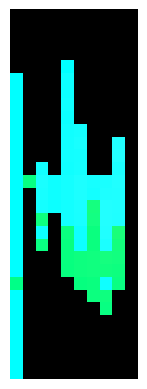

dist min =  tensor(0., dtype=torch.float64)
dist max =  tensor(0.1382, dtype=torch.float64)
mass min =  tensor(0., dtype=torch.float64)
mass max =  tensor(10.4085, dtype=torch.float64)
subh min =  tensor(0., dtype=torch.float64)
subh max =  tensor(1., dtype=torch.float64)


In [21]:
img1 = test
img1 = img1.permute(1, 2, 0).numpy()
plt.imshow(img1)
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()
print("dist min = ", test[0].min())
print("dist max = ", test[0].max())
print("mass min = ", test[1].min())
print("mass max = ", test[1].max())
print("subh min = ", test[2].min())
print("subh max = ", test[2].max())

#### seems ok??

# plot each channel


Dist:


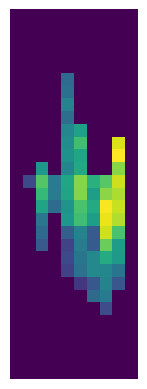


Mass:


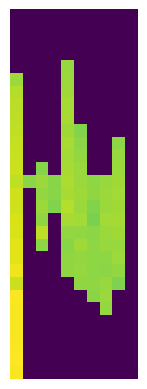


Subhalo


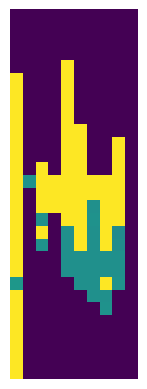

In [22]:
for j in range(3):
    if j == 0:
        print("\nDist:")
    elif j == 1:
        print("\nMass:")
    else:
        print("\nSubhalo")
    img1 = test[j].unsqueeze(0)
    img1 = img1.permute(1, 2, 0).numpy()
    plt.imshow(img1)
    plt.axis('off')  # Optional: Turn off axis ticks and labels
    plt.show()
    


#### also seems ok?

# check zero and nonzero pixels, do all channels predict same for absence/presence of progenitor?

In [23]:
def have_same_zero_values(tensor1, tensor2):
    # Create boolean masks for zero values
    zero_mask1 = (tensor1 == 0)
    zero_mask2 = (tensor2 == 0)
    
    # Compare the boolean masks
    print("the two tensors have zeroes in the same spots =", torch.all(zero_mask1 == zero_mask2).item())
    
    percentage = 100 * torch.sum(zero_mask1 == zero_mask2) / len(zero_mask1.flatten())
    
    print(f"the two tensors have zeroes and nonzero values in {percentage:.2f}% of the same spots")
    
    return

print("distance and mass:")
have_same_zero_values(test[0], test[1])
print("\n")
print("subhalo and mass:")
have_same_zero_values(test[1], test[2])
print("\n")
print("distance and subhalo:")
have_same_zero_values(test[2], test[0])

print("\n")
print("Zero elements:")
for i in range(3):
    zero_count = (test[i] == 0).sum().item()
    total_elements = test[j].numel()
    percentage_zero = (zero_count / total_elements) * 100
    print("Percentage of zero elements:", round(percentage_zero, 2), "%")


distance and mass:
the two tensors have zeroes in the same spots = False
the two tensors have zeroes and nonzero values in 92.07% of the same spots


subhalo and mass:
the two tensors have zeroes in the same spots = False
the two tensors have zeroes and nonzero values in 89.66% of the same spots


distance and subhalo:
the two tensors have zeroes in the same spots = False
the two tensors have zeroes and nonzero values in 97.59% of the same spots


Zero elements:
Percentage of zero elements: 63.79 %
Percentage of zero elements: 55.86 %
Percentage of zero elements: 66.21 %


#### very interesting, none of the channels have the same generation in terms of absence/presence of progenitor.
#### we also see that there is a difference between how many zeros each channel predicts. distance is usually a bit lower than the other two since distance to the main branch in the main branch is 0, but here, mass have a lot more nonezero values than the other two channels

# see number of nonzero entries

In [24]:
nonzero_indices_dist = torch.nonzero(test[0].flatten())
nonzero_values_dist = test[0].flatten()[nonzero_indices_dist[:, 0]]
nonzero_values_dist.shape

torch.Size([105])

In [25]:
nonzero_indices_mass = torch.nonzero(test[1].flatten())
nonzero_values_mass = test[1].flatten()[nonzero_indices_mass[:, 0]]
nonzero_values_mass.shape

torch.Size([128])

In [26]:
nonzero_indices_subh = torch.nonzero(test[2].flatten())
nonzero_values_subh = test[2].flatten()[nonzero_indices_subh[:, 0]]
nonzero_values_subh.shape

torch.Size([98])

# plot nonzero values for each channel

# subhalo

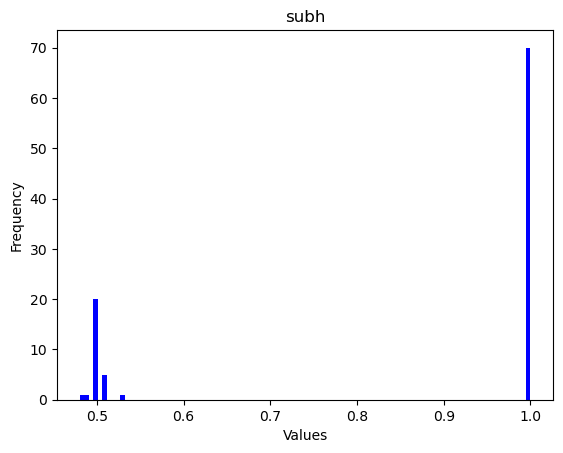

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5100,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000,
        0.5100, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 0.5000, 1.0000,
        0.4800, 1.0000, 0.5100, 0.5000, 1.0000, 0.5000, 1.0000, 0.4900, 1.0000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 1.0000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5300, 0.5000, 0.5000, 1.0000, 0.5100, 1.0000, 0.5000,
        0.5000, 1.0000, 0.5100, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       dtype=torch.float64)

In [27]:
plt.hist(torch.round(nonzero_values_subh, decimals = 10).numpy(), bins=100, color='blue')

# Customize the plot
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('subh')

# Show the plot
plt.show()

nonzero_values_subh

#### we see that there are multiple values that are not exactly 0.5, values like 0.48, 0.49, 0.51, 0.52, 0.53  have been observed. Is this accurate??? if the categorical value is 0.5 exactly. And why is nothing mentioned about this? For me, it is a little bit suspicious that the "off-values" are -/+ 0.01 - 0.03, when the problem uses floats. in the other two variables, the predicted floats have many decimals. Did they do something to deal with it? and if so, what?

# mass

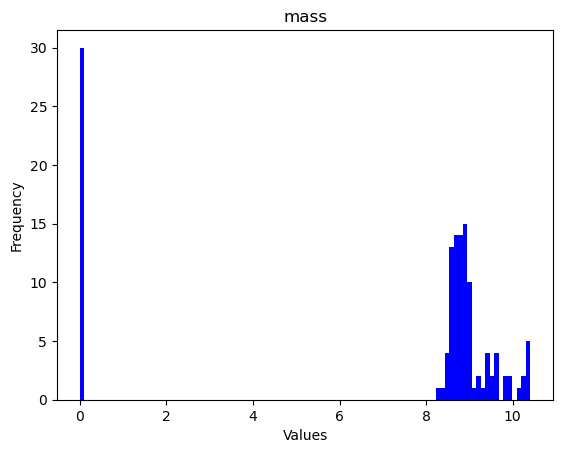

(30,
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 2.0000e-06, 2.0000e-06,
         8.0000e-06, 4.0000e-06, 1.4000e-05, 1.0000e-06, 5.0000e-06, 3.0000e-06,
         6.0000e-06, 2.0000e-05, 1.9000e-05, 7.0000e-06, 1.2000e-05, 2.4000e-05,
         3.3000e-05, 5.0000e-05, 8.1900e-04, 3.8100e-04, 1.9910e-03, 4.8600e-04,
         1.1000e-05, 2.0000e-06, 1.7900e-04, 1.8800e-04, 1.0000e-06, 7.0000e-06],
        dtype=torch.float64))

In [28]:
plt.hist(torch.round(nonzero_values_mass, decimals = 10).numpy(), bins=100, color='blue')

# Customize the plot
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('mass')

# Show the plot
plt.show()

len(nonzero_values_mass[nonzero_values_mass < 2]), nonzero_values_mass[nonzero_values_mass < 2]

#### we see that there are multiple nonzero values that are close to 0. In fact, there are 30 very small nonzero values. remember the variable representation has a total of 29 * 10 = 290 pixels, so 30 is over 10% of the variable pixels. That means over 12% of the mass variable generated has progenitor present when it shouldnt be. In my eyes, that is a discontinuity. It could have been delt with in some way, but they obviously didnt

# dist

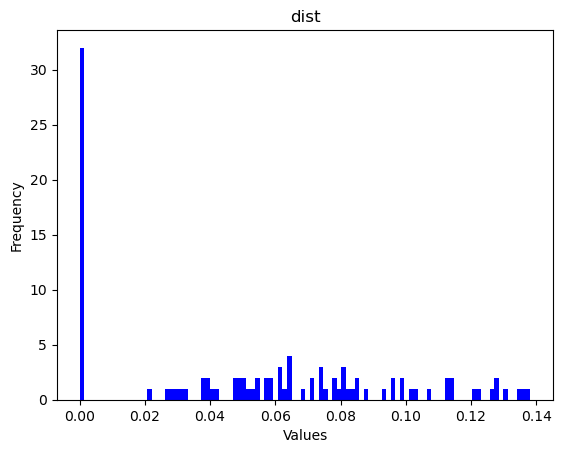

(32,
 tensor([2.3600e-04, 1.0000e-06, 2.0000e-06, 3.0000e-06, 4.0000e-06, 6.0000e-06,
         8.0000e-06, 9.0000e-06, 1.0000e-05, 2.8000e-05, 9.0000e-06, 7.0000e-06,
         1.7000e-05, 1.0000e-06, 7.0000e-06, 1.3000e-05, 2.3000e-05, 5.0000e-06,
         8.0000e-06, 2.4000e-05, 9.0000e-06, 4.0000e-06, 1.2000e-05, 1.4000e-05,
         1.0000e-06, 1.6000e-05, 1.0000e-06, 2.4000e-05, 2.6000e-05, 2.5000e-05,
         2.3000e-05, 1.0000e-06], dtype=torch.float64))

In [29]:
plt.hist(torch.round(nonzero_values_dist, decimals = 10).numpy(), bins=100, color='blue')

# Customize the plot
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('dist')

# Show the plot
plt.show()

len(nonzero_values_dist[nonzero_values_dist < 0.01]), nonzero_values_dist[nonzero_values_dist < 0.01]

#### the same is true for the distance variable

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original:


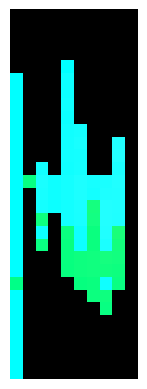

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


zero detection:


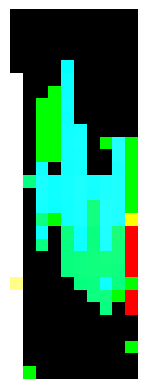


Dist:


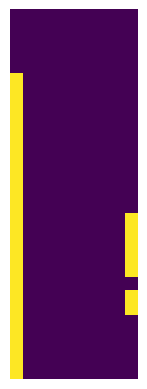


Mass:


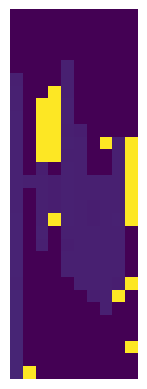

In [30]:
test_zeroes = test.clone()

lower_bound = 0.0
upper_bound = 1.0e-4

# Mask the tensor based on the condition (value between lower_bound and upper_bound)
mask = (test_zeroes > lower_bound) & (test_zeroes <= upper_bound)

# Edit values based on the condition
test_zeroes[mask] = 100

print("original:")
img1 = test
img1 = img1.permute(1, 2, 0).numpy()
plt.imshow(img1)
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()

print("zero detection:")
img1 = test_zeroes
img1 = img1.permute(1, 2, 0).numpy()
plt.imshow(img1)
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()

for j in range(2):
    if j == 0:
        print("\nDist:")
    elif j == 1:
        print("\nMass:")
    else:
        print("\nSubhalo")
    img1 = test_zeroes[j].unsqueeze(0)
    img1 = img1.permute(1, 2, 0).numpy()
    plt.imshow(img1)
    plt.axis('off')  # Optional: Turn off axis ticks and labels
    plt.show()
    


#### here there are a lot going on, so here is a list of behaviors and patterns observed:
- in some cases, both mass and distane have a very low nonzero value predicted, which means both channels technically say its a progenitor present, when it is not.
- mass predict a progenitor present in the beginning of the main branch, so it adds one timestep to the main branch which is bad.
- most of the distance variables "off-values" is in the main branch. The distance variable in the main branch should be 0.0 since distance is a measure from the main branch.
- most of the "off-values" are close to good generated values, however there are multiple issuess:
    - the "off-values" extend a branch with more than 9 values
    - the "off-values" creates discontinuities in branches, that is gaps between progenitors in a branch
    - the "off-values" have created new branches that are not supposed to exist. with "off-values" in both the mass and distance variable

# check total dataset

### dist

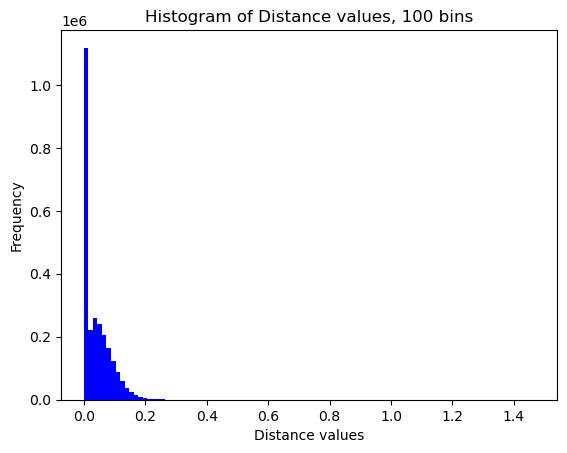

Number of bad nonzero values = 1014873
Percentage of bad nonzero values overall = 9.0898%

Just remember, minimum distance value in training data is 0.000273, and over 9% of total generated data is less than 0.00005


In [31]:
dist = fake_dataset[:, 0]
mass = fake_dataset[:, 1]
subh = fake_dataset[:, 2]

nonzero_indices_dist = torch.nonzero(dist.flatten())
nonzero_values_dist = dist.flatten()[nonzero_indices_dist[:, 0]]

plt.hist(torch.round(nonzero_values_dist, decimals = 4).numpy(), bins=100, color='blue')

# Customize the plot
plt.xlabel('Distance values')
plt.ylabel('Frequency')
plt.title('Histogram of Distance values, 100 bins')

# Show the plot
plt.show()

off_nonzero_values = len(nonzero_values_dist[nonzero_values_dist < 5.0e-5])

print("Number of bad nonzero values =", off_nonzero_values)
print(f"Percentage of bad nonzero values overall = {100 * off_nonzero_values / len(dist.flatten()):.4f}%")
print("\nJust remember, minimum distance value in training data is 0.000273, and over 9% of total generated data is less than 0.00005")

### just below 10% of all distance values are "off-values", that is nonzero values extremely close to zero, mostly are in the main branch

## only sub branches

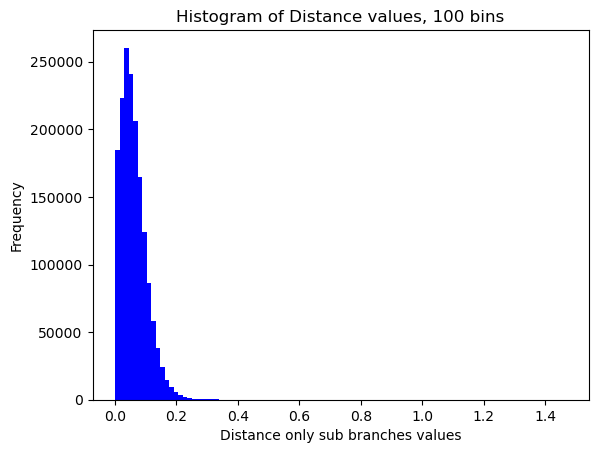

Number of bad nonzero values = 99593
Percentage of bad nonzero values overall = 0.8920%


In [32]:
dist_branches = fake_dataset[:, 0, :, 1:]


nonzero_indices_dist_branches = torch.nonzero(dist_branches.flatten())
nonzero_values_dist_branches = dist_branches.flatten()[nonzero_indices_dist_branches[:, 0]]

plt.hist(torch.round(nonzero_values_dist_branches, decimals = 4).numpy(), bins=100, color='blue')

# Customize the plot
plt.xlabel('Distance only sub branches values')
plt.ylabel('Frequency')
plt.title('Histogram of Distance values, 100 bins')

# Show the plot
plt.show()

off_nonzero_values = len(nonzero_values_dist_branches[nonzero_values_dist_branches < 5.0e-5])

print("Number of bad nonzero values =", off_nonzero_values)
print(f"Percentage of bad nonzero values overall = {100 * off_nonzero_values / len(dist.flatten()):.4f}%")

### mass

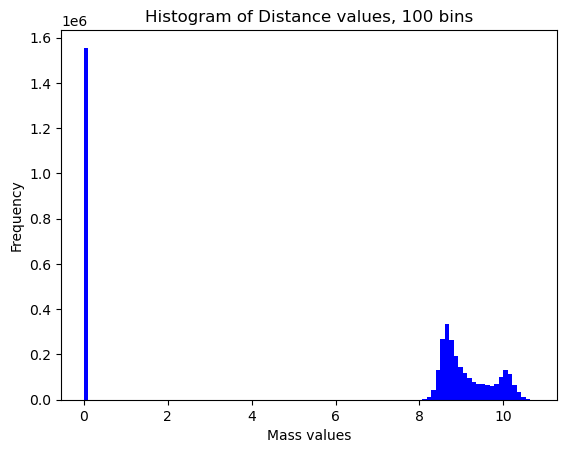

Number of bad nonzero values = 1549243
Percentage of bad nonzero values overall = 13.8759%

Just remember, minimum distance value in training data is 7.6377, and here we test numbers below 0.001


In [33]:
nonzero_indices_mass = torch.nonzero(mass.flatten())
nonzero_values_mass = mass.flatten()[nonzero_indices_mass[:, 0]]

plt.hist(torch.round(nonzero_values_mass, decimals = 4).numpy(), bins=100, color='blue')

# Customize the plot
plt.xlabel('Mass values')
plt.ylabel('Frequency')
plt.title('Histogram of Distance values, 100 bins')

# Show the plot
plt.show()

off_nonzero_values = len(nonzero_values_mass[nonzero_values_mass < 1.0e-3])

print("Number of bad nonzero values =", off_nonzero_values)
print(f"Percentage of bad nonzero values overall = {100 * off_nonzero_values / len(mass.flatten()):.4f}%")
print("\nJust remember, minimum distance value in training data is 7.6377, and here we test numbers below 0.001")

### Over 13% of all mass values are "off-values", that is nonzero values extremely close to zero

### subhalo

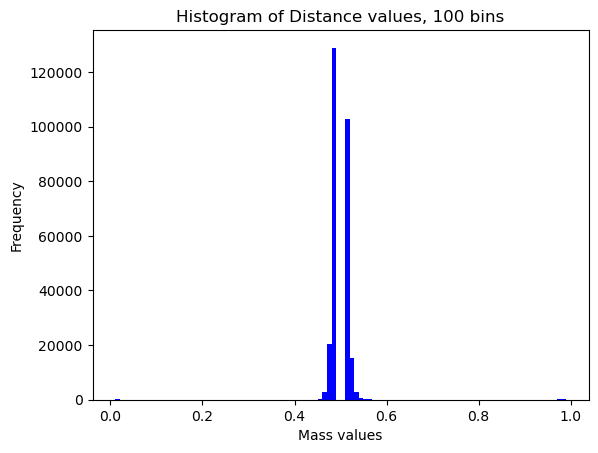

Number of bad nonzero values = 276005
Percentage of bad nonzero values overall = 2.4721%
These values range from 0.01 - 0.99


In [34]:
nonzero_indices_subh = torch.nonzero(subh.flatten())
nonzero_values_subh = subh.flatten()[nonzero_indices_mass[:, 0]]


nonzero_values_subh = nonzero_values_subh[nonzero_values_subh < 1.0]
nonzero_values_subh = nonzero_values_subh[nonzero_values_subh > 0.0]
nonzero_values_subh = nonzero_values_subh[nonzero_values_subh != 0.5]

plt.hist(torch.round(nonzero_values_subh, decimals = 4).numpy(), bins=100, color='blue')

# Customize the plot
plt.xlabel('Mass values')
plt.ylabel('Frequency')
plt.title('Histogram of Distance values, 100 bins')

# Show the plot
plt.show()

off_nonzero_values = len(nonzero_values_subh)

print("Number of bad nonzero values =", off_nonzero_values)
print(f"Percentage of bad nonzero values overall = {100 * off_nonzero_values / len(subh.flatten()):.4f}%")
print(f"These values range from {nonzero_values_subh.min()} - {nonzero_values_subh.max()}")

In [35]:
def count_unique(tensor):
    unique_values, counts = tensor.unique(return_counts=True)
    return unique_values, counts

unique_values, counts = count_unique(nonzero_values_subh)
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0.01, Count: 138
Value: 0.02, Count: 27
Value: 0.03, Count: 21
Value: 0.04, Count: 10
Value: 0.05, Count: 10
Value: 0.06, Count: 5
Value: 0.07, Count: 1
Value: 0.08, Count: 1
Value: 0.09, Count: 4
Value: 0.1, Count: 1
Value: 0.11, Count: 7
Value: 0.12, Count: 1
Value: 0.14, Count: 1
Value: 0.16, Count: 1
Value: 0.17, Count: 2
Value: 0.18, Count: 2
Value: 0.19, Count: 1
Value: 0.2, Count: 1
Value: 0.21, Count: 2
Value: 0.22, Count: 2
Value: 0.23, Count: 1
Value: 0.25, Count: 2
Value: 0.3, Count: 1
Value: 0.31, Count: 1
Value: 0.32, Count: 1
Value: 0.33, Count: 2
Value: 0.35, Count: 4
Value: 0.36, Count: 2
Value: 0.37, Count: 2
Value: 0.38, Count: 4
Value: 0.39, Count: 8
Value: 0.4, Count: 7
Value: 0.41, Count: 3
Value: 0.42, Count: 6
Value: 0.43, Count: 15
Value: 0.44, Count: 20
Value: 0.45, Count: 66
Value: 0.46, Count: 387
Value: 0.47, Count: 2924
Value: 0.48, Count: 20479
Value: 0.49, Count: 128872
Value: 0.51, Count: 102890
Value: 0.52, Count: 15240
Value: 0.53, Count: 2848
V

In [36]:
print(f"The total number of unique values that are not 0.0, 0.5 or 1.0 is {len(unique_values)}")
print(f"The number range from 0.01 - 0.99 with increments of 0.01, and contains all numbers except 0.13, 0.15, 0.24, 0.26, 0.27, 0.28, 0.29, 0.24, 0.68")

The total number of unique values that are not 0.0, 0.5 or 1.0 is 89
The number range from 0.01 - 0.99 with increments of 0.01, and contains all numbers except 0.13, 0.15, 0.24, 0.26, 0.27, 0.28, 0.29, 0.24, 0.68


# This is a huge discontinuity and is not mentioned at all. How do you classify a halo if the generated value is 0.75 or 0.25???

# In my opinion, these are results that should have been mentioned, and then delt with to create consistent generated merger trees.

# check algorithms presented in the papers
# paper 2:

### load data, only uses merger trees with six branches
### no normalization since it is not mentioned in the paper

In [37]:
six_branches = torch.load('data/six_branches_data.pt')
six_branches.shape, six_branches.max()

(torch.Size([8161, 3, 29, 10]), tensor(10.8590, dtype=torch.float64))

In [38]:
six_dataset_short = six_branches[:, :, :, :6]
six_dataset_short.shape

torch.Size([8161, 3, 29, 6])

### make model

In [39]:
class Discriminator_big(nn.Module):
    def __init__(self, nvar, nsnap, nbr, printer):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(nvar, 16, kernel_size=(1, 3), stride=1),
            nn.ELU(),
            nn.Conv2d(16, 32, kernel_size=(1, 3), stride=1),
            nn.ELU(),
            nn.Conv2d(32, 64, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Conv2d(64, 128, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Conv2d(128, 256, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(11776, 1)
        )
        
        
        self.conv1 = nn.Conv2d(nvar, 16, kernel_size=(1, 3), stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 3), stride=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 1), stride=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=(3, 1), stride=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=(3, 1), stride=1)
        self.elu = nn.ELU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(11776, 1)
        self.sigmoid = nn.Sigmoid()
        
        self.printer = printer

    def forward(self, x):
        if self.printer:
            print("\nDiscriminator:")
            print("0:", x.shape)
            x = self.conv1(x)
            print("1:", x.shape)
            x = self.elu(x)
            print("2:", x.shape)
            x = self.conv2(x)
            print("3:", x.shape)
            x = self.elu(x)
            print("4:", x.shape)
            x = self.conv3(x)
            print("5:", x.shape)
            x = self.elu(x)
            print("6:", x.shape)
            x = self.conv4(x)
            print("7:", x.shape)
            x = self.elu(x)
            print("8:", x.shape)
            x = self.conv5(x)
            print("9:", x.shape)
            x = self.elu(x)
            print("10:", x.shape)
            x = self.flatten(x)
            print("11:", x.shape)
            x = self.linear(x)
            print("12:", x.shape)
            return x
        else:
            
            return self.layers(x)


class Encoder_big(nn.Module):
    def __init__(self, nvar, nsnap, nbr, latent_size, printer):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(nvar, 16, kernel_size=(1, 3), stride=1),
            nn.ELU(),
            nn.Conv2d(16, 32, kernel_size=(1, 3), stride=1),
            nn.ELU(),
            nn.Conv2d(32, 64, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Conv2d(64, 128, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Conv2d(128, 256, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(44544, latent_size),
        )
        
        self.conv1 = nn.Conv2d(nvar, 16, kernel_size=(1, 3), stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 3), stride=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 1), stride=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=(3, 1), stride=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=(3, 1), stride=1)
        self.elu = nn.ELU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(11776, latent_size)
        
        self.printer = printer

    def forward(self, x):
        if self.printer:
            print("\nEncoder:")
            print("0:", x.shape)
            x = self.conv1(x)
            print("1:", x.shape)
            x = self.elu(x)
            print("2:", x.shape)
            x = self.conv2(x)
            print("3:", x.shape)
            x = self.elu(x)
            print("4:", x.shape)
            x = self.conv3(x)
            print("5:", x.shape)
            x = self.elu(x)
            print("6:", x.shape)
            x = self.conv4(x)
            print("7:", x.shape)
            x = self.elu(x)
            print("8:", x.shape)
            x = self.conv5(x)
            print("9:", x.shape)
            x = self.elu(x)
            print("10:", x.shape)
            x = self.flatten(x)
            print("11:", x.shape)
            x = self.linear(x)
            print("12:", x.shape)

            return x
        
        else:
            x = self.layers(x)
            return x


class Generator_big(nn.Module):
    def __init__(self, nvar, nsnap, nbr, latent_size, printer):
        super().__init__()

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.ConvTranspose2d(128, 64, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(1, 3), stride=1),
            nn.ELU(),
            nn.ConvTranspose2d(32, 16, kernel_size=(1, 3), stride=1),
            nn.ELU(),
            nn.ConvTranspose2d(16, nvar, kernel_size=(1, 3), stride=1),
            nn.Sigmoid(),
        )
        
        self.linear = nn.Linear(latent_size, 11776)
        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=(3, 1), stride=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=(3, 1), stride=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=(1, 3), stride=1)
        self.deconv4 = nn.ConvTranspose2d(32, 16, kernel_size=(1, 3), stride=1)
        self.deconv5 = nn.ConvTranspose2d(16, nvar, kernel_size=(1, 3), stride=1)
        
        self.printer = printer


    def forward(self, x):
        if self.printer:
            print("\nGenerator:")
            print("0:", x.shape)
            x = self.linear(x)
            print("1:", x.shape)
            x = self.elu(x)
            print("2:", x.shape)
            x = x.view(-1, 256, 23, 2)
            print("3:", x.shape)
            x = self.deconv1(x)
            print("4:", x.shape)
            x = self.elu(x)
            print("5:", x.shape)
            x = self.deconv2(x)
            print("6:", x.shape)
            x = self.elu(x)
            print("7:", x.shape)
            x = self.deconv3(x)
            print("8:", x.shape)
            x = self.elu(x)
            print("9:", x.shape)
            x = self.deconv4(x)
            print("10:", x.shape)
            x = self.elu(x)
            print("11:", x.shape)
            x = self.deconv5(x)
            print("12:", x.shape)
            x = self.sigmoid(x)
            print("13:", x.shape)

            return x
        else:
            x = self.elu(self.linear(x))
            x = x.view(-1, 256, 23, 2)

            return self.layers(x)
        

### pass a batch through and check layer output

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nsnap = six_dataset_short.shape[2]
nbr = six_dataset_short.shape[3]
nvar = six_dataset_short.shape[1]
printer = True

num_epochs = 1
lr = 3e-4
batch_size = 128
latent_size = 100

train_loader = DataLoader(six_dataset_short, shuffle=True, batch_size = batch_size)
discriminator_CGAN = Discriminator_big(nvar, nsnap, nbr, printer).to(device)
encoder_CGAN = Encoder_big(nvar, nsnap, nbr, latent_size, printer).to(device)
generator_CGAN = Generator_big(nvar, nsnap, nbr, latent_size, printer).to(device)

for real_data in tqdm.tqdm(train_loader):
    
    real = real_data.to(dtype=torch.float32)
    
    test_disc = discriminator_CGAN(real)
    test_enc = encoder_CGAN(real)
    test_gen = generator_CGAN(test_enc)

    
    break

  0%|                                                    | 0/64 [00:00<?, ?it/s]


Discriminator:
0: torch.Size([128, 3, 29, 6])
1: torch.Size([128, 16, 29, 4])
2: torch.Size([128, 16, 29, 4])
3: torch.Size([128, 32, 29, 2])
4: torch.Size([128, 32, 29, 2])
5: torch.Size([128, 64, 27, 2])
6: torch.Size([128, 64, 27, 2])
7: torch.Size([128, 128, 25, 2])
8: torch.Size([128, 128, 25, 2])
9: torch.Size([128, 256, 23, 2])
10: torch.Size([128, 256, 23, 2])
11: torch.Size([128, 11776])
12: torch.Size([128, 1])

Encoder:
0: torch.Size([128, 3, 29, 6])
1: torch.Size([128, 16, 29, 4])
2: torch.Size([128, 16, 29, 4])
3: torch.Size([128, 32, 29, 2])
4: torch.Size([128, 32, 29, 2])
5: torch.Size([128, 64, 27, 2])
6: torch.Size([128, 64, 27, 2])
7: torch.Size([128, 128, 25, 2])
8: torch.Size([128, 128, 25, 2])


  0%|                                                    | 0/64 [00:00<?, ?it/s]

9: torch.Size([128, 256, 23, 2])
10: torch.Size([128, 256, 23, 2])
11: torch.Size([128, 11776])
12: torch.Size([128, 100])

Generator:
0: torch.Size([128, 100])
1: torch.Size([128, 11776])
2: torch.Size([128, 11776])
3: torch.Size([128, 256, 23, 2])
4: torch.Size([128, 128, 25, 2])
5: torch.Size([128, 128, 25, 2])
6: torch.Size([128, 64, 27, 2])
7: torch.Size([128, 64, 27, 2])
8: torch.Size([128, 32, 27, 4])
9: torch.Size([128, 32, 27, 4])
10: torch.Size([128, 16, 27, 6])
11: torch.Size([128, 16, 27, 6])
12: torch.Size([128, 3, 27, 8])
13: torch.Size([128, 3, 27, 8])


### I made some changes in the linear layer and how to reshape the image from latent space in the generator to make sure the image is passed through the whole process. We can see that the shapes mismatch from what the paper architecure says, which makes it very hard to reproduce the model and the results